In [2]:
!pip show transformers

Name: transformers
Version: 4.30.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/vlad/.local/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: sentence-transformers


In [4]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [5]:
SEED = 0

## Прикручиваем LaBSE.

In [6]:
from sentence_transformers import SentenceTransformer

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [7]:
sentences = ["This is an example sentence", "Each sentence is converted"]

LaBSE_name = 'sentence-transformers/LaBSE'
LaBSE_small_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

sentence_model = SentenceTransformer(LaBSE_name)

for param in sentence_model.parameters():
    param.requires_grad = False

In [8]:
import torch
with torch.no_grad():
    embeddings = sentence_model.encode(sentences)
    print(embeddings.shape)

(2, 768)


## Учим

In [9]:
from sentence_transformers import ParallelSentencesDataset, losses
from datasets import load_dataset
from torch.utils.data import DataLoader

In [10]:
from transformers import set_seed

In [11]:
# Define your fine-tuning task
dataset = load_dataset("RicardoRei/wmt-da-human-evaluation",split="train")

train_dataset = dataset.filter(lambda example: (example["year"] < 2022) & (example["lp"] in ["en-ru", "zh-en", "en-de"]))
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)

In [12]:
checkpoint = "bigscience/mt0-base"

In [13]:
from transformers import pipeline

In [14]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [15]:
try:
    del pipe
except NameError:
    pass
pipe = pipeline("text2text-generation",
                model=checkpoint,
                device="cpu",
                tokenizer=tokenizer
               )

Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-base and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for param in pipe.model.encoder.parameters():
    param.requires_grad = False

In [17]:
for param in pipe.model.decoder.parameters():
    param.requires_grad = False

In [18]:
SEED += 1
set_seed(SEED)

In [19]:
import torch

In [20]:
def get_gimba_prompt(source_lang, source_seg, target_lang, target_seg, reference_seg):
    return f'''Score the following translation from {source_lang} to {target_lang} with respect to the human reference on a continuous scale from 0 to 100, where a score of 0 means "no meaning preserved" and score of 100 means "perfect meaning and grammar".
    {source_lang} source: "{source_seg}"
    {target_lang} human reference: {reference_seg}
    {target_lang} translation: "{target_seg}"
    Score:'''

In [21]:
def get_gimba_prompt_with_injection(source_lang, source_seg, target_lang, target_seg, reference_seg, injected_str):
    return f'''Score the following translation from {source_lang} to {target_lang} with respect to the human reference on a continuous scale from 0 to 100, where a score of 0 means "no meaning preserved" and score of 100 means "perfect meaning and grammar".
    {source_lang} source: "{source_seg}"
    {target_lang} human reference: {reference_seg}
    {target_lang} translation: "{target_seg}"
    Special encoding of inputs: {injected_str}
    Score:'''

In [22]:
for elem in train_dataset:
    print(elem["lp"], elem["src"])
    break

en-de For older generations, singing together is seen as more important, it was part of their daily life both at school and in their leisure time, she explains.


In [23]:
abbr_to_language = {
    "en" : "English",
    "de" : "Deutsch",
    "zh" : "Chinese",
    "ru" : "Russian"
}

In [24]:
for elem in train_dataset:
    print(elem)
    break

{'lp': 'en-de', 'src': 'For older generations, singing together is seen as more important, it was part of their daily life both at school and in their leisure time, she explains.', 'mt': 'Für ältere Generationen wird Gesang gemeinsam als wichtiger angesehen, es gehörte zu ihrem Alltag sowohl in der Schule als auch in ihrer Freizeit, erklärt sie.', 'ref': 'In den älteren Generationen hatte das gemeinsame Singen einen viel höheren Stellenwert, es gehörte zum Alltag, sowohl in der Schule als auch in der Freizeit, erklärt sie.', 'score': 0.225731637374983, 'raw': 76.0, 'annotators': 1, 'domain': 'news', 'year': 2017}


In [25]:
import numpy as np

In [26]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data,
                 train_name, target_name, ref_name, lp_name, src_name):
        self.inputs = []
        self.refs = []
        self.lps = []
        self.srcs = []
        
        self.targets = []
        for element in data:
            self.inputs.append(element[train_name])
            
            self.lps.append(element[lp_name])
            self.targets.append(element[target_name])
            
            self.refs.append(element[ref_name])
            #self.srcs.extend([element[src_name]] * len(element[target_name]))
            self.srcs.append(element[src_name])
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        torch.cuda.empty_cache()
        # Implement logic to retrieve input and target data
        
        lang_from, lang_to = self.lps[idx].split("-")
        lang_from = abbr_to_language[lang_from]
        lang_to = abbr_to_language[lang_to]
        
        injected_str = ""
        with torch.no_grad():
            for sentence in [self.srcs[idx], self.inputs[idx], self.refs[idx]]:
                if sentence is None:
                    sentence = " "
                encoding = sentence_model.encode(sentence)
                injected_str += str(np.round(encoding.mean(), 2))
                injected_str += " "
                injected_str += str(np.round(encoding.std(ddof=1), 2))
                injected_str += " "
                injected_str += str(encoding.argmax())
                injected_str += " "
        
        prompt = get_gimba_prompt(lang_from, self.srcs[idx], lang_to, self.inputs[idx], self.refs[idx])
        
        # print(prompt)
        
        input_data = tokenizer(prompt, return_tensors="pt")    
        
        for key in input_data.keys():
            input_data[key] = input_data[key][0]
        
        # print(input_data["input_ids"].shape)
        
        input_data['labels'] = torch.Tensor([self.targets[idx]])
        
        return input_data

In [27]:
finetune_dataset = MyDataset(train_dataset, "mt", "raw", "ref", "lp", "src")

input_tensor = torch.unsqueeze(
                            torch.normal(torch.zeros(768),
                                        torch.ones(768)).type(torch.int32),
                            dim=0)

pipe.model.decoder.block[0].forward(input_tensor)

In [29]:
pad_token = 259

In [30]:
from transformers import Trainer, TrainingArguments

In [31]:
class EmbedFinetuneTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        return outputs.loss

In [32]:
from transformers import DataCollatorForSeq2Seq

In [33]:
collator = DataCollatorForSeq2Seq(tokenizer, label_pad_token_id = pad_token)

In [34]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=0.02,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=15,
)

trainer = EmbedFinetuneTrainer(
    model=pipe.model,
    args=training_args,
    train_dataset=finetune_dataset,
    data_collator=collator
)

/home/vlad/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Subclass and override trainer for custom behaviour

In [35]:
trainer.train()

/home/vlad/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
15,26.354400
30,26.342500
45,26.314900
60,26.121800
75,26.023900
90,26.018000
105,25.980200
120,25.868600
135,25.921200
150,25.690500


TrainOutput(global_step=226, training_loss=25.913636975583778, metrics={'train_runtime': 5411.4204, 'train_samples_per_second': 1.335, 'train_steps_per_second': 0.042, 'total_flos': 6455664373137408.0, 'train_loss': 25.913636975583778, 'epoch': 0.02})

In [36]:
import pickle

In [37]:
with open("pipeline_model_tuned.pickle", "wb") as file:
    pickle.dump(pipe.model, file)

In [38]:
def get_gimba_prompt_with_injection(source_lang, source_seg, target_lang, target_seg, reference_seg, injected_str):
    return f'''Score the following translation from {input_lang} to {target_lang} with respect to the human reference with one to five stars.
Where one star means "Nonsense/No meaning preserved",
two stars mean "Some meaning preserved, but not understandable",
three stars mean "Some meaning preserved and understandable",
four stars mean "Most meaning preserved with possibly few grammar mistakes",
five stars mean "Prefect meaning and grammar".
    {source_lang} source: "{source_seg}"
    {target_lang} human reference: {reference_seg}
    {target_lang} translation: "{target_seg}"
    Special encoding of inputs: {injected_str}
    Score:'''

In [39]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data,
                 train_name, target_name, ref_name, lp_name, src_name):
        self.inputs = []
        self.refs = []
        self.lps = []
        self.srcs = []
        
        self.targets = []
        for element in data:
            self.inputs.append(element[train_name])
            
            self.lps.append(element[lp_name])
            self.targets.append(element[target_name])
            
            self.refs.append(element[ref_name])
            #self.srcs.extend([element[src_name]] * len(element[target_name]))
            self.srcs.append(element[src_name])
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        torch.cuda.empty_cache()
        # Implement logic to retrieve input and target data
        
        lang_from, lang_to = self.lps[idx].split("-")
        lang_from = abbr_to_language[lang_from]
        lang_to = abbr_to_language[lang_to]
        
        injected_str = ""
        with torch.no_grad():
            for sentence in [self.srcs[idx], self.inputs[idx], self.refs[idx]]:
                if sentence is None:
                    sentence = " "
                encoding = sentence_model.encode(sentence)
                injected_str += str(np.round(encoding.mean(), 2))
                injected_str += " "
                injected_str += str(np.round(encoding.std(ddof=1), 2))
                injected_str += " "
                injected_str += str(encoding.argmax())
                injected_str += " "
        
        prompt = get_gimba_prompt(lang_from, self.srcs[idx], lang_to, self.inputs[idx], self.refs[idx])
        
        # print(prompt)
        
        input_data = tokenizer(prompt, return_tensors="pt")    
        
        for key in input_data.keys():
            input_data[key] = input_data[key][0]
        
        # print(input_data["input_ids"].shape)
        
        input_data['labels'] = torch.Tensor([self.targets[idx]])
        
        return input_data

In [40]:
finetune_dataset = MyDataset(train_dataset, "mt", "raw", "ref", "lp", "src")

input_tensor = torch.unsqueeze(
                            torch.normal(torch.zeros(768),
                                        torch.ones(768)).type(torch.int32),
                            dim=0)

pipe.model.decoder.block[0].forward(input_tensor)

In [41]:
finetune_dataset[1]

{'input_ids': tensor([ 62906,    287,    259,   9877,  53802,    702,   5413,    288,  22606,
           514,   7521,    288,    287,   6910,  33749,    351,    259,    262,
           317,  93317,  39009,    702,    497,    288,    966,    261,    259,
          3001,    259,    262,  18575,    304,    497,    259,  12909,    313,
           505,  31560,    786,  42816,    311,    305,  18575,    304,    966,
           259,  12909,    313, 137988,  31560,    305,    259, 164814,   1191,
          5413,  10219,    267,    313,   2009,    259,  93967,    263,    418,
          3506,    261,    259,  99195,  14355,    702,   6604,   2225,    288,
           287,  16780,    347,    317, 100180,    277,    263, 226932,    468,
         24107,    351,   6665,   2454,  22606,   6910,  33749,    267,   1659,
          5973,    270,  59058,  40503,    364, 143520,    272,    261,    398,
          7873,    795,    442,  50389, 145701,   1581,   7565,   2774,  71571,
           318, 162194,   

In [42]:
pad_token = 259

In [43]:
from transformers import Trainer, TrainingArguments

In [44]:
class EmbedFinetuneTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        return outputs.loss

In [45]:
from transformers import DataCollatorForSeq2Seq

In [46]:
collator = DataCollatorForSeq2Seq(tokenizer, label_pad_token_id = pad_token)

In [49]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=0.02,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=15,
)

trainer = EmbedFinetuneTrainer(
    model=pipe.model,
    args=training_args,
    train_dataset=finetune_dataset,
    data_collator=collator
)

In [50]:
trainer.train()

Step,Training Loss
15,25.542600
30,25.524600
45,25.498500
60,25.293800
75,25.201000
90,25.195900
105,25.158500
120,25.047100
135,25.097800
150,24.872600


TrainOutput(global_step=226, training_loss=25.090930618016067, metrics={'train_runtime': 5006.2004, 'train_samples_per_second': 1.443, 'train_steps_per_second': 0.045, 'total_flos': 6455664373137408.0, 'train_loss': 25.090930618016067, 'epoch': 0.02})

In [51]:
with open("pipeline_model_tuned_2.pickle", "wb") as file:
    pickle.dump(pipe.model, file)

In [75]:
try:
    del pipe
except NameError:
    pass
pipe = pipeline("text2text-generation",
                model=checkpoint,
                device="cpu",
                tokenizer=tokenizer
               )

Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-base and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
import numpy as np

vocabulary = tokenizer.get_vocab()
embeddings = []
for token in vocabulary:
    input_ids = tokenizer.encode(token, return_tensors='pt')
    
    # remove BOS, EOS
    if input_ids[0][0] == 259:
        input_ids = input_ids[0, 1]
    else:
        input_ids = input_ids[0, 0]
        
    # update list
    embeddings.append(pipe.model.get_input_embeddings()(input_ids))

embeddings_matrix = torch.stack(embeddings, dim=0)
embeddings_matrix = embeddings_matrix.detach().numpy()

embeddings_matrix.shape

tokenizer_inverse_vocab = {value : key for key, value in tokenizer.get_vocab().items()}

In [77]:
def find_closest_row_cosine(matrix, vector):
    # Calculate the cosine similarity between the vector and each row of the matrix
    similarities = np.dot(matrix, vector) / (np.linalg.norm(matrix, axis=1) * np.linalg.norm(vector))
    
    # Find the index of the row with the highest cosine similarity
    closest_row_index = np.argmax(similarities)
    
    return closest_row_index

In [81]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data,
                 train_name, target_name, ref_name, lp_name, src_name):
        self.inputs = []
        self.refs = []
        self.lps = []
        self.srcs = []
        
        self.targets = []
        for element in data:
            self.inputs.append(element[train_name])
            
            self.lps.append(element[lp_name])
            self.targets.append(element[target_name])
            
            self.refs.append(element[ref_name])
            #self.srcs.extend([element[src_name]] * len(element[target_name]))
            self.srcs.append(element[src_name])
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        torch.cuda.empty_cache()
        # Implement logic to retrieve input and target data
        
        lang_from, lang_to = self.lps[idx].split("-")
        lang_from = abbr_to_language[lang_from]
        lang_to = abbr_to_language[lang_to]
        
        injected_str = ""
        with torch.no_grad():
            for sentence in [self.srcs[idx], self.inputs[idx], self.refs[idx]]:
                if sentence is None:
                    sentence = " "
                labse_embeds = sentence_model.encode(sentence)
                # labse_embeds = np.concatenate([labse_embeds, np.zeros(256)]) #mt5-large
                closest_idx = find_closest_row_cosine(embeddings_matrix, labse_embeds)
                spec_token = tokenizer_inverse_vocab[closest_idx]
                injected_str += spec_token
                injected_str += " "
        
        prompt = get_gimba_prompt(lang_from, self.srcs[idx], lang_to, self.inputs[idx], self.refs[idx])
        
        # print(prompt)
        
        input_data = tokenizer(prompt, return_tensors="pt")    
        
        for key in input_data.keys():
            input_data[key] = input_data[key][0]
        
        # print(input_data["input_ids"].shape)
        
        input_data['labels'] = torch.Tensor([self.targets[idx]])
        
        return input_data

In [82]:
finetune_dataset = MyDataset(train_dataset, "mt", "raw", "ref", "lp", "src")

input_tensor = torch.unsqueeze(
                            torch.normal(torch.zeros(768),
                                        torch.ones(768)).type(torch.int32),
                            dim=0)

pipe.model.decoder.block[0].forward(input_tensor)

In [83]:
finetune_dataset[1]

{'input_ids': tensor([ 62906,    287,    259,   9877,  53802,    702,   5413,    288,  22606,
           514,   7521,    288,    287,   6910,  33749,    351,    259,    262,
           317,  93317,  39009,    702,    497,    288,    966,    261,    259,
          3001,    259,    262,  18575,    304,    497,    259,  12909,    313,
           505,  31560,    786,  42816,    311,    305,  18575,    304,    966,
           259,  12909,    313, 137988,  31560,    305,    259, 164814,   1191,
          5413,  10219,    267,    313,   2009,    259,  93967,    263,    418,
          3506,    261,    259,  99195,  14355,    702,   6604,   2225,    288,
           287,  16780,    347,    317, 100180,    277,    263, 226932,    468,
         24107,    351,   6665,   2454,  22606,   6910,  33749,    267,   1659,
          5973,    270,  59058,  40503,    364, 143520,    272,    261,    398,
          7873,    795,    442,  50389, 145701,   1581,   7565,   2774,  71571,
           318, 162194,   

In [84]:
pad_token = 259

In [85]:
from transformers import Trainer, TrainingArguments

In [86]:
class EmbedFinetuneTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        return outputs.loss

In [87]:
from transformers import DataCollatorForSeq2Seq

In [88]:
collator = DataCollatorForSeq2Seq(tokenizer, label_pad_token_id = pad_token)

In [201]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=0.005,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=15,
)

trainer = EmbedFinetuneTrainer(
    model=pipe.model,
    args=training_args,
    train_dataset=finetune_dataset,
    data_collator=collator
)

In [ ]:
trainer.train()

/home/vlad/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


In [ ]:
with open("pipeline_model_tuned_3.pickle", "wb") as file:
    pickle.dump(pipe.model, file)

In [59]:
import pandas as pd

In [63]:
df_stars_stats = pd.DataFrame({"Step" : np.arange(1, 16) * 15, "Loss" : [26.3544,26.3364,26.3103,
 26.1056, 26.0128,26.0077, 25.9703,
 25.8589, 25.9096,25.6844, 25.5968,
 25.6655, 25.6906,25.5317, 25.5452]})

In [139]:
df_onehundred_stats = pd.DataFrame({"Step" : np.arange(1, 16) * 15, 
"Loss" : [26.354400, 26.282500, 26.254900, 26.221800,
26.183900, 26.118000, 26.060200, 25.958600,
25.911200, 25.820500, 25.715700, 25.721000,
25.610200, 25.639200, 25.611400]})
df_onehundred_embeds = pd.DataFrame({"Step" : np.arange(1, 26) * 15, 
"Loss" : [26.3544    , 26.2344    , 26.1344    , 26.13407751, 25.97407751,
       25.90407751, 25.81407751, 25.81475984, 25.81561868, 25.40561868,
       25.26561868, 25.19561868, 25.06561868, 25.06537471, 25.06623023,
       24.97623058, 24.91428024, 24.86631166, 24.83623067, 24.80018917,
       24.7872728 , 24.83621636, 24.72132773, 24.63621242, 24.59415081]})

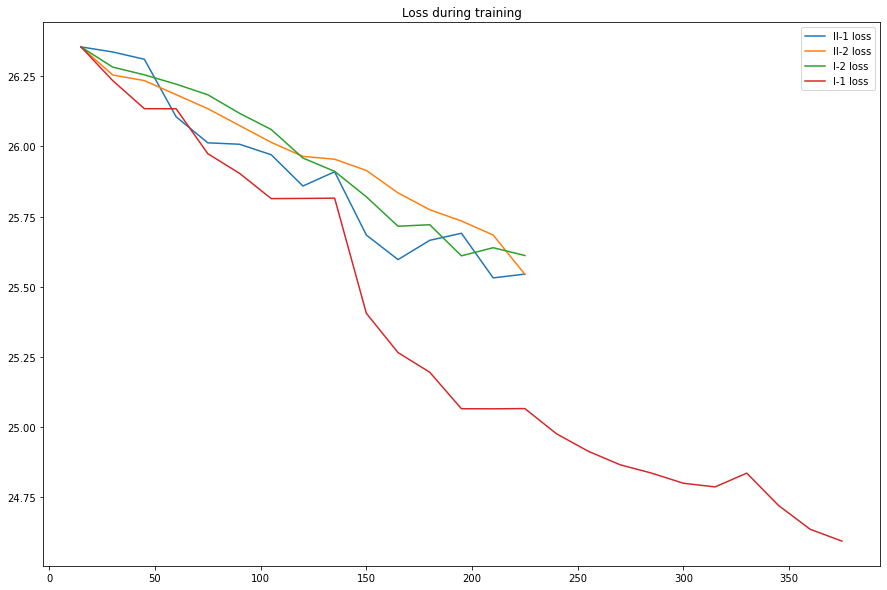

In [200]:
plt.figure(figsize=(15,10))

plt.plot(np.array(df_stars_stats["Step"]), 
         np.array(df_stars_stats["Loss"]) ,
        label = "II-1 loss")
plt.plot(np.array(df_stars_embeds["Step"]), 
         df_stars_embeds["Loss"],
        label = "II-2 loss")
plt.plot(np.array(df_onehundred_stats["Step"]), 
         np.array(df_onehundred_stats["Loss"]),
        label = "I-2 loss")
plt.plot(np.array(df_onehundred_embeds["Step"]), 
         np.array(df_onehundred_embeds["Step"]),
        label = "I-1 loss")
plt.title("Loss during training")
plt.legend()
plt.show()